In [1]:
#Chap5

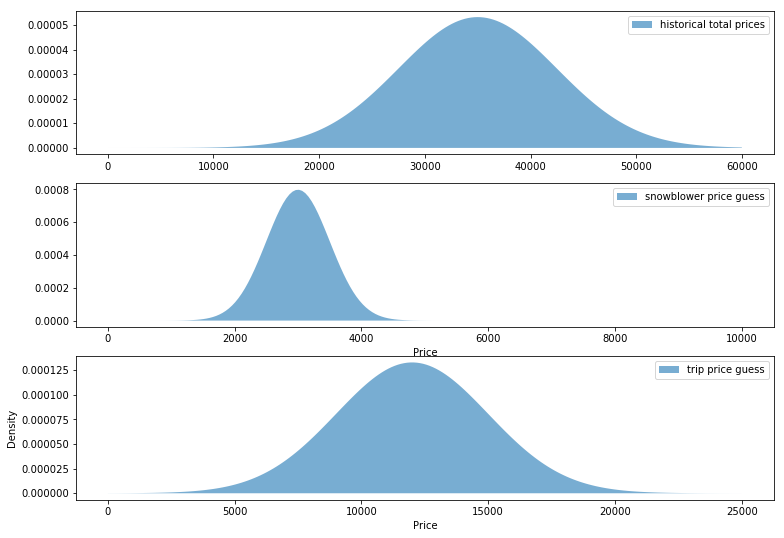

In [7]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
plt.fill_between(x, 0, norm_pdf(x, 35000, 7500), lw=3, alpha=0.6, label="historical total prices")
plt.legend()


plt.subplot(312)
x = np.linspace(0, 10000, 200)
plt.fill_between(x, 0, norm_pdf(x, 3000, 500), lw=3, alpha=0.6, label="snowblower price guess")
plt.xlabel("Price")
plt.legend()

plt.subplot(313)
x = np.linspace(0, 25000, 200)
plt.fill_between(x, 0, norm_pdf(x, 12000, 3000), lw=3, alpha=0.6, label="trip price guess")
plt.xlabel("Price")
plt.legend()

plt.ylabel("Density")

In [73]:
import pymc as pm

# 平均
data_mu = [3000, 12000]
# 標準偏差
data_std = [5000, 3000]

# 事前分布の平均と分散
mu_prior = 35000
std_prior = 7500

# それぞれ確率分布を作成
true_price = pm.Normal("true_price", mu_prior, 1.0/std_prior**2)
prize_1 = pm.Normal("first_price", data_mu[0], 1.0/data_std[0]**2)
prize_2 = pm.Normal("second_price", data_mu[1], 1.0/data_std[1]**2)

price_estimate = prize_1 + prize_2

# prize_1とprize_2の合計とtrue_priceとの差をerrorとして使う
@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
    return pm.normal_like(true_price, price_estimate, 1/(3000)**2)

mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(50000, 10000)

# true_priceのサンプリング
price_trace = mcmc.trace("true_price")[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 5.3 sec

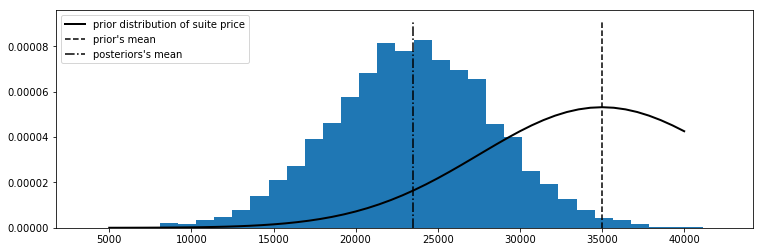

In [74]:
figsize(12.5, 4)
import scipy.stats as stats

# 事前分布
x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2, label="prior distribution of suite price")

# 事後分布
_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")

# それぞれの平均をプロット
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), linestyles="--", label="prior's mean")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), linestyles="-.", label="posteriors's mean")

plt.legend(loc="upper left")

In [36]:
def showcase_loss(guess, true_price, risk=80000):
    if true_price < guess:
        return risk
    elif abs(tru_price- guess) <= 250:
        return -2*np.abs(true_price)
    else:
        return np.abs(true_price - guess - 250)    

In [67]:
a = np.asarray([-1,2,3])
b = np.asarray([2,-3,-3])
c = a < b
print(c)
print(a[c])
print(a[~c])
d = [abs(b) > 2]
print(d)
b[d]

def func(e, b):
    return abs(e+b)

f = lambda l1, l2: func(l1, l2)

print(f(a, b))
print(price_trace[0])

[ True False False]
[-1]
[2 3]
[array([False,  True,  True], dtype=bool)]
[1 1 0]
18166.3047505


(5000, 30000)

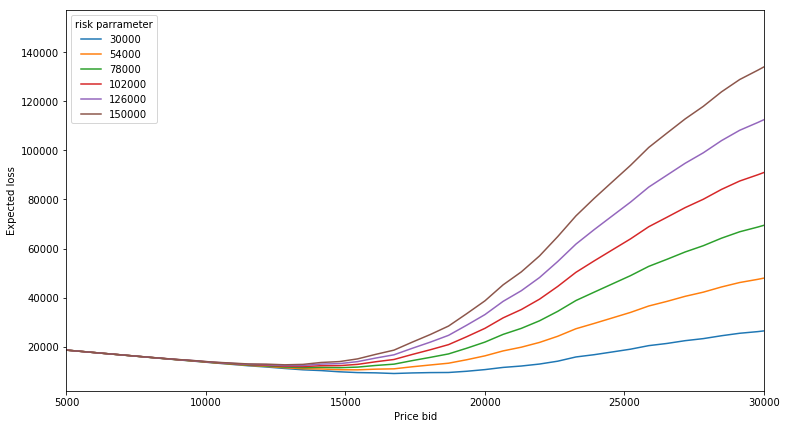

In [64]:
figsize(12.5, 7)
def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    # true_priceより予想が高いインデックスのマスク
    ix = true_price < guess
    # true_priceのほうが高い要素のみ 単純な差の絶対値でlossを計算
    loss[~ix] = np.abs(guess - true_price[~ix])
    # true_priceと予想との差が250ドル以下の要素のマスク
    close_mask = [abs(true_price - guess) <= 250]
    # true_priceと予想との差が250ドル以下の要素についてtrue_priceに-2をかけてlossを計算または上書き
    loss[close_mask] = -2 * true_price[close_mask]
    # 予想が高いインデックスはriskをlossに採用
    loss[ix] = risk
    return loss

# 5000から50000まで70点サンプル
guesses = np.linspace(5000, 50000, 70)
# 30000から150000まで6点サンプル
risks = np.linspace(30000, 150000, 6)

# 予想とリスクごとに損失の平均を計算するlamdba式　price_traceは真の分布からサンプリングした価格
expected_loss = lambda guess, risk: showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    # リスクごとに損失の平均を計算
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)
    
plt.legend(title='risk parrameter')
plt.xlabel("Price bid")
plt.ylabel("Expected loss")
plt.xlim(5000, 30000)

Optimization terminated successfully.
         Current function value: 9184.136649
         Iterations: 34
         Function evaluations: 70
minimum at risk 30000: 16957.71
Optimization terminated successfully.
         Current function value: 10673.130204
         Iterations: 30
         Function evaluations: 62
minimum at risk 54000: 15007.34
Optimization terminated successfully.
         Current function value: 11487.711206
         Iterations: 29
         Function evaluations: 61
minimum at risk 78000: 14203.27
Optimization terminated successfully.
         Current function value: 12015.960998
         Iterations: 31
         Function evaluations: 65
minimum at risk 102000: 13312.97
Optimization terminated successfully.
         Current function value: 12460.675979
         Iterations: 35
         Function evaluations: 73
minimum at risk 126000: 13302.01
Optimization terminated successfully.
         Current function value: 12905.275979
         Iterations: 35
         Function eva

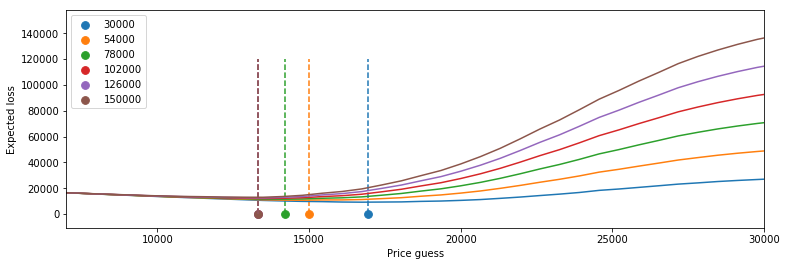

In [81]:
import scipy.optimize as sop

ax = plt.subplot(111)

for  _p in risks:
    # color
    _color = next(ax._get_lines.prop_cycler)
    # scipyのfmin
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,), disp=True)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s=60, color=_color['color'], label="%d" % _p)
    plt.vlines(_min_results, 0, 120000, color=_color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))
plt.xlabel("Price guess")
plt.ylabel("Expected loss")
plt.xlim(7000, 30000)
plt.legend()